<h2> This notebook covers:</h2> 
<h3>- Loading ESC-50 & Voice Commands datasets <br>
- Preprocessing and feature extraction (MFCC, spectrograms) <br>
- Training deep learning models (CNN/RNN)<br>
- Evaluating classification performance</h3>

In [3]:
import os
import shutil
import pandas as pd
import numpy as np
from glob import glob
import subprocess
import tensorflow as tf
import tensorflow_hub as hub
from pydub import AudioSegment
import librosa
import soundfile as sf
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

In [1]:
# --- Robust path setup ---
import os, sys
from pathlib import Path

# Get repo root (two levels up from notebooks/)
NB_DIR = Path.cwd()
for cand in [NB_DIR, *NB_DIR.parents]:
    if (cand / "src").exists():
        sys.path.insert(0, str(cand))
        ROOT = cand
        break

# Import utilities from src/
from src.utils import project_root, data_dir

ROOT = project_root()
DATA = data_dir()

print("Project root:", ROOT)
print("Data dir:", DATA)

Project root: /Users/adarshthakur/Downloads/Smart_Home_Intruder_detection
Data dir: /Users/adarshthakur/Downloads/Smart_Home_Intruder_detection/data


In [4]:

from pathlib import Path

# Base dataset directory 
base_dir = DATA / "ESC-50-master"

# Metadata CSV and audio directory
meta_csv_path = base_dir / "meta" / "esc50.csv"
audio_dir = base_dir / "audio"

# Output directory 
output_dir = ROOT / "outputs" / "esc_intruder_audio"
output_dir.mkdir(parents=True, exist_ok=True)

print("Meta CSV:", meta_csv_path)
print("Audio dir:", audio_dir)
print("Output dir:", output_dir)

# Relevant Intruder Detection Categories 
target_categories = [
    "dog",
    "door_wood_knock",
    "siren",
    "footsteps"
]

# Load metadata CSV
df = pd.read_csv(meta_csv_path)
filtered_df = df[df['category'].isin(target_categories)]

print(f"✅ Found {len(filtered_df)} relevant audio samples.")

# Copy audio files into label-specific folders
for _, row in filtered_df.iterrows():
    category = row["category"]
    filename = row["filename"]

    src_path = os.path.join(audio_dir, filename)
    label_folder = os.path.join(output_dir, category)
    os.makedirs(label_folder, exist_ok=True)

    dest_path = os.path.join(label_folder, filename)
    shutil.copy2(src_path, dest_path)

print("🎧 Audio files successfully organized by category.")


Meta CSV: /Users/adarshthakur/Downloads/Smart_Home_Intruder_detection/data/ESC-50-master/meta/esc50.csv
Audio dir: /Users/adarshthakur/Downloads/Smart_Home_Intruder_detection/data/ESC-50-master/audio
Output dir: /Users/adarshthakur/Downloads/Smart_Home_Intruder_detection/outputs/esc_intruder_audio
✅ Found 160 relevant audio samples.
🎧 Audio files successfully organized by category.


In [22]:
import pandas as pd
df = pd.read_csv(DATA / "ESC-50-master" / "meta" / "esc50.csv")


In [5]:
# === Build outputs/esc_intruder_audio from ESC-50 ===
import pandas as pd
from pathlib import Path
import shutil

ESC_ROOT   = DATA / "ESC-50-master"
META_CSV   = ESC_ROOT / "meta" / "esc50.csv"
AUDIO_DIR  = ESC_ROOT / "audio"              # ESC-50 stores wavs directly under audio/
OUT_ESC    = ROOT / "outputs" / "esc_intruder_audio"
OUT_ESC.mkdir(parents=True, exist_ok=True)

# Map ESC-50 categories -> your target labels
# (These four come from ESC-50; gunshot/glassbreak you already have from VOIC)
LABEL_MAP = {
    "dog": "dog",
    "footsteps": "footsteps",
    "siren": "siren",
    "door_wood_knock": "door_wood_knock",
}

df = pd.read_csv(META_CSV)

# Keep only rows we need
df_sel = df[df["category"].isin(LABEL_MAP.keys())].copy()

copied = 0
missing = 0
for _, row in df_sel.iterrows():
    src = AUDIO_DIR / row["filename"]          # ESC-50 files are directly in audio/
    dst_dir = OUT_ESC / LABEL_MAP[row["category"]]
    dst_dir.mkdir(parents=True, exist_ok=True)
    if src.exists():
        shutil.copy2(src, dst_dir / row["filename"])
        copied += 1
    else:
        missing += 1

print(f"✅ Copied from ESC-50 → {OUT_ESC}")
for k in LABEL_MAP.values():
    n = len(list((OUT_ESC / k).glob("*.wav")))
    print(f"  {k}: {n} files")
if missing:
    print(f"⚠️ Missing files in ESC-50/audio/: {missing}")

✅ Copied from ESC-50 → /Users/adarshthakur/Downloads/Smart_Home_Intruder_detection/outputs/esc_intruder_audio
  dog: 40 files
  footsteps: 40 files
  siren: 40 files
  door_wood_knock: 40 files


In [17]:

from pathlib import Path

# Input audio (inside DATA folder)
input_dir = DATA / "clean" / "audio"

# Output audio (inside repo outputs/)
output_dir = DATA /"clean"/ "audio_converted"
output_dir.mkdir(parents=True, exist_ok=True)

print("Input dir:", input_dir)
print("Output dir:", output_dir)

for filename in os.listdir(input_dir):
    if not filename.endswith(".wav"):
        continue

    src_path = os.path.join(input_dir, filename)
    dst_path = os.path.join(output_dir, filename)

    cmd = [
        "ffmpeg", "-y",
        "-i", src_path,
        "-acodec", "pcm_s16le",  # Convert to 16-bit PCM
        "-ar", "44100",          # Set sample rate to 44.1kHz
        dst_path
    ]

    result = subprocess.run(cmd, stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
    if result.returncode == 0:
        print(f"✅ Converted: {filename}")
    else:
        print(f"❌ Failed: {filename}")


Input dir: /Users/adarshthakur/Downloads/untitled folder/data/clean/audio
Output dir: /Users/adarshthakur/Downloads/untitled folder/data/clean/audio_converted
✅ Converted: synthetic_034.wav
✅ Converted: synthetic_020.wav
✅ Converted: synthetic_008.wav
✅ Converted: synthetic_140.wav
✅ Converted: synthetic_154.wav
✅ Converted: synthetic_168.wav
✅ Converted: synthetic_183.wav
✅ Converted: synthetic_197.wav
✅ Converted: synthetic_196.wav
✅ Converted: synthetic_182.wav
✅ Converted: synthetic_169.wav
✅ Converted: synthetic_155.wav
✅ Converted: synthetic_141.wav
✅ Converted: synthetic_009.wav
✅ Converted: synthetic_021.wav
✅ Converted: synthetic_035.wav
✅ Converted: synthetic_023.wav
✅ Converted: synthetic_037.wav
✅ Converted: synthetic_157.wav
✅ Converted: synthetic_143.wav
✅ Converted: synthetic_194.wav
✅ Converted: synthetic_180.wav
✅ Converted: synthetic_181.wav
✅ Converted: synthetic_195.wav
✅ Converted: synthetic_142.wav
✅ Converted: synthetic_156.wav
✅ Converted: synthetic_036.wav
✅ Co

In [18]:
print("Annotation count:", len(list(annotation_dir.glob("*.txt"))))
print("Converted audio count:", len(list(audio_dir.glob("*.wav"))) )

# Check first few
for f in list(annotation_dir.glob("*.txt"))[:5]:
    wav = audio_dir / f.name.replace(".txt", ".wav")
    print(f.name, "-> exists?" , wav.exists())

Annotation count: 207
Converted audio count: 207
synthetic_023.txt -> exists? True
synthetic_037.txt -> exists? True
synthetic_157.txt -> exists? True
synthetic_143.txt -> exists? True
synthetic_194.txt -> exists? True


In [19]:

from pathlib import Path

# CONFIG
base_path = DATA / "clean"   # inside your dataset folder
annotation_dir = base_path / "annotation"
audio_dir = base_path / "audio_converted"

# Outputs stay inside repo under outputs/
output_dir = ROOT / "outputs" / "voice_audio_dataset"
output_dir.mkdir(parents=True, exist_ok=True)

print("Annotation dir:", annotation_dir)
print("Audio dir:", audio_dir)
print("Output dir:", output_dir)

target_classes = {"gunshot", "glassbreak"}
clip_count = 0

for file in sorted(os.listdir(annotation_dir)):
    if not file.endswith(".txt"):
        continue

    annotation_path = os.path.join(annotation_dir, file)
    audio_filename = file.replace(".txt", ".wav")
    audio_path = os.path.join(audio_dir, audio_filename)

    if not os.path.exists(audio_path):
        print(f"❌ Audio missing for {audio_filename}")
        continue

    try:
        audio = AudioSegment.from_wav(audio_path)
    except Exception as e:
        print(f"⚠️ Error loading audio {audio_filename}: {e}")
        continue

    with open(annotation_path, "r") as f:
        for line in f:
            try:
                start, end, label = line.strip().split()
                if label not in target_classes:
                    continue

                start_ms = int(float(start) * 1000)
                end_ms = int(float(end) * 1000)

                segment = audio[start_ms:end_ms]
                label_dir = os.path.join(output_dir, label)
                os.makedirs(label_dir, exist_ok=True)

                out_name = f"{clip_count:04d}_{audio_filename}"
                out_path = os.path.join(label_dir, out_name)
                segment.export(out_path, format="wav")
                clip_count += 1
                print(f"✅ Saved: {out_path}")

            except Exception as e:
                print(f"⚠️ Failed to parse line in {file}: {line.strip()} | Error: {e}")

print(f"\n Finished! Total clips saved: {clip_count}")


Annotation dir: /Users/adarshthakur/Downloads/untitled folder/data/clean/annotation
Audio dir: /Users/adarshthakur/Downloads/untitled folder/data/clean/audio_converted
Output dir: /Users/adarshthakur/Downloads/untitled folder/outputs/voice_audio_dataset
✅ Saved: /Users/adarshthakur/Downloads/untitled folder/outputs/voice_audio_dataset/gunshot/0000_synthetic_001.wav
✅ Saved: /Users/adarshthakur/Downloads/untitled folder/outputs/voice_audio_dataset/glassbreak/0001_synthetic_001.wav
✅ Saved: /Users/adarshthakur/Downloads/untitled folder/outputs/voice_audio_dataset/gunshot/0002_synthetic_001.wav
✅ Saved: /Users/adarshthakur/Downloads/untitled folder/outputs/voice_audio_dataset/glassbreak/0003_synthetic_001.wav
✅ Saved: /Users/adarshthakur/Downloads/untitled folder/outputs/voice_audio_dataset/gunshot/0004_synthetic_001.wav
✅ Saved: /Users/adarshthakur/Downloads/untitled folder/outputs/voice_audio_dataset/glassbreak/0005_synthetic_001.wav
✅ Saved: /Users/adarshthakur/Downloads/untitled folde

In [24]:
from pathlib import Path
import shutil

# CONFIG
# ESC and Voice come from your outputs (processed datasets)
esc_dir = ROOT / "outputs" / "esc_intruder_audio"
voic_dir = ROOT / "outputs" / "voice_audio_dataset"

# Final merged dataset goes into outputs/final_intruder_audio
final_dir = ROOT / "outputs" / "final_intruder_audio"
final_dir.mkdir(parents=True, exist_ok=True)

# TARGET CLASSES
classes = ["dog", "gunshot", "glassbreak", "footsteps", "door_wood_knock", "siren"]

print("ESC dir:", esc_dir)
print("Voice dir:", voic_dir)
print("Final dataset dir:", final_dir)

for label in classes:
    final_label_dir = os.path.join(final_dir, label)
    os.makedirs(final_label_dir, exist_ok=True)

    # Check ESC dataset
    esc_label_dir = os.path.join(esc_dir, label)
    if os.path.exists(esc_label_dir):
        for f in os.listdir(esc_label_dir):
            src = os.path.join(esc_label_dir, f)
            dst = os.path.join(final_label_dir, f"esc_{f}")
            shutil.copy2(src, dst)

    # Check VOIC dataset
    voic_label_dir = os.path.join(voic_dir, label)
    if os.path.exists(voic_label_dir):
        for f in os.listdir(voic_label_dir):
            src = os.path.join(voic_label_dir, f)
            dst = os.path.join(final_label_dir, f"voic_{f}")
            shutil.copy2(src, dst)

print("All intruder-related audio clips are consolidated into:")
print(f" {final_dir}")


ESC dir: /Users/adarshthakur/Downloads/untitled folder/outputs/esc_intruder_audio
Voice dir: /Users/adarshthakur/Downloads/untitled folder/outputs/voice_audio_dataset
Final dataset dir: /Users/adarshthakur/Downloads/untitled folder/outputs/final_intruder_audio
All intruder-related audio clips are consolidated into:
 /Users/adarshthakur/Downloads/untitled folder/outputs/final_intruder_audio


In [25]:


from pathlib import Path

# CONFIG
# Input: processed ESC dataset lives inside outputs
input_dir = ROOT / "outputs" / "esc_intruder_audio"

# Output: new augmented dataset also goes under outputs
output_dir = ROOT / "outputs" / "augmented_intruder_audio"
output_dir.mkdir(parents=True, exist_ok=True)

print("Input dir:", input_dir)
print("Output dir:", output_dir)
# Augmentation Functions 

def apply_time_stretch(y, sr):
    return librosa.effects.time_stretch(y, rate=1.1)

def apply_pitch_shift(y, sr):
    return librosa.effects.pitch_shift(y, sr, n_steps=2)

def apply_noise(y, sr):
    noise = np.random.randn(len(y))
    return y + 0.005 * noise

AUGMENTATIONS = [apply_time_stretch, apply_pitch_shift, apply_noise]
AUGS_PER_FILE = 3

#  Processing 

for label in os.listdir(input_dir):
    label_path = os.path.join(input_dir, label)
    if not os.path.isdir(label_path):
        continue

    output_label_path = os.path.join(output_dir, label)
    os.makedirs(output_label_path, exist_ok=True)

    for filename in tqdm(os.listdir(label_path), desc=f"Augmenting {label}"):
        if not filename.endswith(".wav"):
            continue

        file_path = os.path.join(label_path, filename)
        try:
            y, sr = librosa.load(file_path, sr=None)
        except Exception as e:
            print(f"❌ Failed to load {filename}: {e}")
            continue

        for i, aug_func in enumerate(AUGMENTATIONS[:AUGS_PER_FILE]):
            try:
                y_aug = aug_func(y, sr)
                new_name = f"aug_{i}_{filename}"
                save_path = os.path.join(output_label_path, new_name)
                sf.write(save_path, y_aug, sr)
                print(f"✅ Saved: {save_path}")
            except Exception as e:
                print(f"⚠️ Failed {filename} with {aug_func.__name__}: {e}")


Input dir: /Users/adarshthakur/Downloads/untitled folder/outputs/esc_intruder_audio
Output dir: /Users/adarshthakur/Downloads/untitled folder/outputs/augmented_intruder_audio


Augmenting siren:  12%|███▎                      | 5/40 [00:01<00:10,  3.47it/s]

✅ Saved: /Users/adarshthakur/Downloads/untitled folder/outputs/augmented_intruder_audio/siren/aug_0_4-90014-B-42.wav
⚠️ Failed 4-90014-B-42.wav with apply_pitch_shift: pitch_shift() takes 1 positional argument but 2 positional arguments (and 1 keyword-only argument) were given
✅ Saved: /Users/adarshthakur/Downloads/untitled folder/outputs/augmented_intruder_audio/siren/aug_2_4-90014-B-42.wav
✅ Saved: /Users/adarshthakur/Downloads/untitled folder/outputs/augmented_intruder_audio/siren/aug_0_3-51376-A-42.wav
⚠️ Failed 3-51376-A-42.wav with apply_pitch_shift: pitch_shift() takes 1 positional argument but 2 positional arguments (and 1 keyword-only argument) were given
✅ Saved: /Users/adarshthakur/Downloads/untitled folder/outputs/augmented_intruder_audio/siren/aug_2_3-51376-A-42.wav
✅ Saved: /Users/adarshthakur/Downloads/untitled folder/outputs/augmented_intruder_audio/siren/aug_0_1-76831-E-42.wav
⚠️ Failed 1-76831-E-42.wav with apply_pitch_shift: pitch_shift() takes 1 positional argument 

Augmenting siren:  32%|████████▏                | 13/40 [00:02<00:02, 10.75it/s]

✅ Saved: /Users/adarshthakur/Downloads/untitled folder/outputs/augmented_intruder_audio/siren/aug_0_3-51909-B-42.wav
⚠️ Failed 3-51909-B-42.wav with apply_pitch_shift: pitch_shift() takes 1 positional argument but 2 positional arguments (and 1 keyword-only argument) were given
✅ Saved: /Users/adarshthakur/Downloads/untitled folder/outputs/augmented_intruder_audio/siren/aug_2_3-51909-B-42.wav
✅ Saved: /Users/adarshthakur/Downloads/untitled folder/outputs/augmented_intruder_audio/siren/aug_0_1-76831-A-42.wav
⚠️ Failed 1-76831-A-42.wav with apply_pitch_shift: pitch_shift() takes 1 positional argument but 2 positional arguments (and 1 keyword-only argument) were given
✅ Saved: /Users/adarshthakur/Downloads/untitled folder/outputs/augmented_intruder_audio/siren/aug_2_1-76831-A-42.wav
✅ Saved: /Users/adarshthakur/Downloads/untitled folder/outputs/augmented_intruder_audio/siren/aug_0_2-43806-A-42.wav
⚠️ Failed 2-43806-A-42.wav with apply_pitch_shift: pitch_shift() takes 1 positional argument 

Augmenting siren:  52%|█████████████▏           | 21/40 [00:02<00:00, 19.07it/s]

✅ Saved: /Users/adarshthakur/Downloads/untitled folder/outputs/augmented_intruder_audio/siren/aug_0_3-58772-A-42.wav
⚠️ Failed 3-58772-A-42.wav with apply_pitch_shift: pitch_shift() takes 1 positional argument but 2 positional arguments (and 1 keyword-only argument) were given
✅ Saved: /Users/adarshthakur/Downloads/untitled folder/outputs/augmented_intruder_audio/siren/aug_2_3-58772-A-42.wav
✅ Saved: /Users/adarshthakur/Downloads/untitled folder/outputs/augmented_intruder_audio/siren/aug_0_5-133989-A-42.wav
⚠️ Failed 5-133989-A-42.wav with apply_pitch_shift: pitch_shift() takes 1 positional argument but 2 positional arguments (and 1 keyword-only argument) were given
✅ Saved: /Users/adarshthakur/Downloads/untitled folder/outputs/augmented_intruder_audio/siren/aug_2_5-133989-A-42.wav
✅ Saved: /Users/adarshthakur/Downloads/untitled folder/outputs/augmented_intruder_audio/siren/aug_0_1-76831-C-42.wav
⚠️ Failed 1-76831-C-42.wav with apply_pitch_shift: pitch_shift() takes 1 positional argume

Augmenting siren:  72%|██████████████████▏      | 29/40 [00:02<00:00, 26.37it/s]

✅ Saved: /Users/adarshthakur/Downloads/untitled folder/outputs/augmented_intruder_audio/siren/aug_0_4-90014-A-42.wav
⚠️ Failed 4-90014-A-42.wav with apply_pitch_shift: pitch_shift() takes 1 positional argument but 2 positional arguments (and 1 keyword-only argument) were given
✅ Saved: /Users/adarshthakur/Downloads/untitled folder/outputs/augmented_intruder_audio/siren/aug_2_4-90014-A-42.wav
✅ Saved: /Users/adarshthakur/Downloads/untitled folder/outputs/augmented_intruder_audio/siren/aug_0_1-76831-D-42.wav
⚠️ Failed 1-76831-D-42.wav with apply_pitch_shift: pitch_shift() takes 1 positional argument but 2 positional arguments (and 1 keyword-only argument) were given
✅ Saved: /Users/adarshthakur/Downloads/untitled folder/outputs/augmented_intruder_audio/siren/aug_2_1-76831-D-42.wav
✅ Saved: /Users/adarshthakur/Downloads/untitled folder/outputs/augmented_intruder_audio/siren/aug_0_5-150409-A-42.wav
⚠️ Failed 5-150409-A-42.wav with apply_pitch_shift: pitch_shift() takes 1 positional argumen

Augmenting siren: 100%|█████████████████████████| 40/40 [00:02<00:00, 14.24it/s]


✅ Saved: /Users/adarshthakur/Downloads/untitled folder/outputs/augmented_intruder_audio/siren/aug_0_5-160551-A-42.wav
⚠️ Failed 5-160551-A-42.wav with apply_pitch_shift: pitch_shift() takes 1 positional argument but 2 positional arguments (and 1 keyword-only argument) were given
✅ Saved: /Users/adarshthakur/Downloads/untitled folder/outputs/augmented_intruder_audio/siren/aug_2_5-160551-A-42.wav
✅ Saved: /Users/adarshthakur/Downloads/untitled folder/outputs/augmented_intruder_audio/siren/aug_0_1-31482-B-42.wav
⚠️ Failed 1-31482-B-42.wav with apply_pitch_shift: pitch_shift() takes 1 positional argument but 2 positional arguments (and 1 keyword-only argument) were given
✅ Saved: /Users/adarshthakur/Downloads/untitled folder/outputs/augmented_intruder_audio/siren/aug_2_1-31482-B-42.wav
✅ Saved: /Users/adarshthakur/Downloads/untitled folder/outputs/augmented_intruder_audio/siren/aug_0_2-72688-A-42.wav
⚠️ Failed 2-72688-A-42.wav with apply_pitch_shift: pitch_shift() takes 1 positional argume

Augmenting dog:  20%|█████▌                      | 8/40 [00:00<00:00, 38.60it/s]

✅ Saved: /Users/adarshthakur/Downloads/untitled folder/outputs/augmented_intruder_audio/dog/aug_0_3-170015-A-0.wav
⚠️ Failed 3-170015-A-0.wav with apply_pitch_shift: pitch_shift() takes 1 positional argument but 2 positional arguments (and 1 keyword-only argument) were given
✅ Saved: /Users/adarshthakur/Downloads/untitled folder/outputs/augmented_intruder_audio/dog/aug_2_3-170015-A-0.wav
✅ Saved: /Users/adarshthakur/Downloads/untitled folder/outputs/augmented_intruder_audio/dog/aug_0_1-59513-A-0.wav
⚠️ Failed 1-59513-A-0.wav with apply_pitch_shift: pitch_shift() takes 1 positional argument but 2 positional arguments (and 1 keyword-only argument) were given
✅ Saved: /Users/adarshthakur/Downloads/untitled folder/outputs/augmented_intruder_audio/dog/aug_2_1-59513-A-0.wav
✅ Saved: /Users/adarshthakur/Downloads/untitled folder/outputs/augmented_intruder_audio/dog/aug_0_2-122104-A-0.wav
⚠️ Failed 2-122104-A-0.wav with apply_pitch_shift: pitch_shift() takes 1 positional argument but 2 positio

Augmenting dog:  40%|██████████▊                | 16/40 [00:00<00:00, 38.68it/s]

✅ Saved: /Users/adarshthakur/Downloads/untitled folder/outputs/augmented_intruder_audio/dog/aug_0_4-199261-A-0.wav
⚠️ Failed 4-199261-A-0.wav with apply_pitch_shift: pitch_shift() takes 1 positional argument but 2 positional arguments (and 1 keyword-only argument) were given
✅ Saved: /Users/adarshthakur/Downloads/untitled folder/outputs/augmented_intruder_audio/dog/aug_2_4-199261-A-0.wav
✅ Saved: /Users/adarshthakur/Downloads/untitled folder/outputs/augmented_intruder_audio/dog/aug_0_3-180256-A-0.wav
⚠️ Failed 3-180256-A-0.wav with apply_pitch_shift: pitch_shift() takes 1 positional argument but 2 positional arguments (and 1 keyword-only argument) were given
✅ Saved: /Users/adarshthakur/Downloads/untitled folder/outputs/augmented_intruder_audio/dog/aug_2_3-180256-A-0.wav
✅ Saved: /Users/adarshthakur/Downloads/untitled folder/outputs/augmented_intruder_audio/dog/aug_0_4-184575-A-0.wav
⚠️ Failed 4-184575-A-0.wav with apply_pitch_shift: pitch_shift() takes 1 positional argument but 2 posi

Augmenting dog:  60%|████████████████▏          | 24/40 [00:00<00:00, 38.72it/s]

✅ Saved: /Users/adarshthakur/Downloads/untitled folder/outputs/augmented_intruder_audio/dog/aug_0_1-85362-A-0.wav
⚠️ Failed 1-85362-A-0.wav with apply_pitch_shift: pitch_shift() takes 1 positional argument but 2 positional arguments (and 1 keyword-only argument) were given
✅ Saved: /Users/adarshthakur/Downloads/untitled folder/outputs/augmented_intruder_audio/dog/aug_2_1-85362-A-0.wav
✅ Saved: /Users/adarshthakur/Downloads/untitled folder/outputs/augmented_intruder_audio/dog/aug_0_4-182395-A-0.wav
⚠️ Failed 4-182395-A-0.wav with apply_pitch_shift: pitch_shift() takes 1 positional argument but 2 positional arguments (and 1 keyword-only argument) were given
✅ Saved: /Users/adarshthakur/Downloads/untitled folder/outputs/augmented_intruder_audio/dog/aug_2_4-182395-A-0.wav
✅ Saved: /Users/adarshthakur/Downloads/untitled folder/outputs/augmented_intruder_audio/dog/aug_0_4-207124-A-0.wav
⚠️ Failed 4-207124-A-0.wav with apply_pitch_shift: pitch_shift() takes 1 positional argument but 2 positio

Augmenting dog:  80%|█████████████████████▌     | 32/40 [00:00<00:00, 39.08it/s]

✅ Saved: /Users/adarshthakur/Downloads/untitled folder/outputs/augmented_intruder_audio/dog/aug_0_1-110389-A-0.wav
⚠️ Failed 1-110389-A-0.wav with apply_pitch_shift: pitch_shift() takes 1 positional argument but 2 positional arguments (and 1 keyword-only argument) were given
✅ Saved: /Users/adarshthakur/Downloads/untitled folder/outputs/augmented_intruder_audio/dog/aug_2_1-110389-A-0.wav
✅ Saved: /Users/adarshthakur/Downloads/untitled folder/outputs/augmented_intruder_audio/dog/aug_0_4-191687-A-0.wav
⚠️ Failed 4-191687-A-0.wav with apply_pitch_shift: pitch_shift() takes 1 positional argument but 2 positional arguments (and 1 keyword-only argument) were given
✅ Saved: /Users/adarshthakur/Downloads/untitled folder/outputs/augmented_intruder_audio/dog/aug_2_4-191687-A-0.wav
✅ Saved: /Users/adarshthakur/Downloads/untitled folder/outputs/augmented_intruder_audio/dog/aug_0_3-155312-A-0.wav
⚠️ Failed 3-155312-A-0.wav with apply_pitch_shift: pitch_shift() takes 1 positional argument but 2 posi

Augmenting dog: 100%|███████████████████████████| 40/40 [00:01<00:00, 38.63it/s]


✅ Saved: /Users/adarshthakur/Downloads/untitled folder/outputs/augmented_intruder_audio/dog/aug_0_4-192236-A-0.wav
⚠️ Failed 4-192236-A-0.wav with apply_pitch_shift: pitch_shift() takes 1 positional argument but 2 positional arguments (and 1 keyword-only argument) were given
✅ Saved: /Users/adarshthakur/Downloads/untitled folder/outputs/augmented_intruder_audio/dog/aug_2_4-192236-A-0.wav
✅ Saved: /Users/adarshthakur/Downloads/untitled folder/outputs/augmented_intruder_audio/dog/aug_0_1-30226-A-0.wav
⚠️ Failed 1-30226-A-0.wav with apply_pitch_shift: pitch_shift() takes 1 positional argument but 2 positional arguments (and 1 keyword-only argument) were given
✅ Saved: /Users/adarshthakur/Downloads/untitled folder/outputs/augmented_intruder_audio/dog/aug_2_1-30226-A-0.wav
✅ Saved: /Users/adarshthakur/Downloads/untitled folder/outputs/augmented_intruder_audio/dog/aug_0_2-114587-A-0.wav
⚠️ Failed 2-114587-A-0.wav with apply_pitch_shift: pitch_shift() takes 1 positional argument but 2 positio

Augmenting footsteps:  20%|████▍                 | 8/40 [00:00<00:00, 38.03it/s]

✅ Saved: /Users/adarshthakur/Downloads/untitled folder/outputs/augmented_intruder_audio/footsteps/aug_0_5-234855-A-25.wav
⚠️ Failed 5-234855-A-25.wav with apply_pitch_shift: pitch_shift() takes 1 positional argument but 2 positional arguments (and 1 keyword-only argument) were given
✅ Saved: /Users/adarshthakur/Downloads/untitled folder/outputs/augmented_intruder_audio/footsteps/aug_2_5-234855-A-25.wav
✅ Saved: /Users/adarshthakur/Downloads/untitled folder/outputs/augmented_intruder_audio/footsteps/aug_0_4-198962-A-25.wav
⚠️ Failed 4-198962-A-25.wav with apply_pitch_shift: pitch_shift() takes 1 positional argument but 2 positional arguments (and 1 keyword-only argument) were given
✅ Saved: /Users/adarshthakur/Downloads/untitled folder/outputs/augmented_intruder_audio/footsteps/aug_2_4-198962-A-25.wav
✅ Saved: /Users/adarshthakur/Downloads/untitled folder/outputs/augmented_intruder_audio/footsteps/aug_0_3-94343-A-25.wav
⚠️ Failed 3-94343-A-25.wav with apply_pitch_shift: pitch_shift() ta

Augmenting footsteps:  40%|████████▍            | 16/40 [00:00<00:00, 37.04it/s]

✅ Saved: /Users/adarshthakur/Downloads/untitled folder/outputs/augmented_intruder_audio/footsteps/aug_0_1-155858-E-25.wav
⚠️ Failed 1-155858-E-25.wav with apply_pitch_shift: pitch_shift() takes 1 positional argument but 2 positional arguments (and 1 keyword-only argument) were given
✅ Saved: /Users/adarshthakur/Downloads/untitled folder/outputs/augmented_intruder_audio/footsteps/aug_2_1-155858-E-25.wav
✅ Saved: /Users/adarshthakur/Downloads/untitled folder/outputs/augmented_intruder_audio/footsteps/aug_0_2-209473-A-25.wav
⚠️ Failed 2-209473-A-25.wav with apply_pitch_shift: pitch_shift() takes 1 positional argument but 2 positional arguments (and 1 keyword-only argument) were given
✅ Saved: /Users/adarshthakur/Downloads/untitled folder/outputs/augmented_intruder_audio/footsteps/aug_2_2-209473-A-25.wav
✅ Saved: /Users/adarshthakur/Downloads/untitled folder/outputs/augmented_intruder_audio/footsteps/aug_0_2-209472-A-25.wav
⚠️ Failed 2-209472-A-25.wav with apply_pitch_shift: pitch_shift() 

Augmenting footsteps:  60%|████████████▌        | 24/40 [00:00<00:00, 37.48it/s]

✅ Saved: /Users/adarshthakur/Downloads/untitled folder/outputs/augmented_intruder_audio/footsteps/aug_0_2-209474-A-25.wav
⚠️ Failed 2-209474-A-25.wav with apply_pitch_shift: pitch_shift() takes 1 positional argument but 2 positional arguments (and 1 keyword-only argument) were given
✅ Saved: /Users/adarshthakur/Downloads/untitled folder/outputs/augmented_intruder_audio/footsteps/aug_2_2-209474-A-25.wav
✅ Saved: /Users/adarshthakur/Downloads/untitled folder/outputs/augmented_intruder_audio/footsteps/aug_0_2-209475-A-25.wav
⚠️ Failed 2-209475-A-25.wav with apply_pitch_shift: pitch_shift() takes 1 positional argument but 2 positional arguments (and 1 keyword-only argument) were given
✅ Saved: /Users/adarshthakur/Downloads/untitled folder/outputs/augmented_intruder_audio/footsteps/aug_2_2-209475-A-25.wav
✅ Saved: /Users/adarshthakur/Downloads/untitled folder/outputs/augmented_intruder_audio/footsteps/aug_0_1-223162-A-25.wav
⚠️ Failed 1-223162-A-25.wav with apply_pitch_shift: pitch_shift() 

Augmenting footsteps:  80%|████████████████▊    | 32/40 [00:00<00:00, 37.74it/s]

✅ Saved: /Users/adarshthakur/Downloads/untitled folder/outputs/augmented_intruder_audio/footsteps/aug_0_1-155858-F-25.wav
⚠️ Failed 1-155858-F-25.wav with apply_pitch_shift: pitch_shift() takes 1 positional argument but 2 positional arguments (and 1 keyword-only argument) were given
✅ Saved: /Users/adarshthakur/Downloads/untitled folder/outputs/augmented_intruder_audio/footsteps/aug_2_1-155858-F-25.wav
✅ Saved: /Users/adarshthakur/Downloads/untitled folder/outputs/augmented_intruder_audio/footsteps/aug_0_4-218304-A-25.wav
⚠️ Failed 4-218304-A-25.wav with apply_pitch_shift: pitch_shift() takes 1 positional argument but 2 positional arguments (and 1 keyword-only argument) were given
✅ Saved: /Users/adarshthakur/Downloads/untitled folder/outputs/augmented_intruder_audio/footsteps/aug_2_4-218304-A-25.wav
✅ Saved: /Users/adarshthakur/Downloads/untitled folder/outputs/augmented_intruder_audio/footsteps/aug_0_3-103597-A-25.wav
⚠️ Failed 3-103597-A-25.wav with apply_pitch_shift: pitch_shift() 

Augmenting footsteps: 100%|█████████████████████| 40/40 [00:01<00:00, 37.75it/s]


✅ Saved: /Users/adarshthakur/Downloads/untitled folder/outputs/augmented_intruder_audio/footsteps/aug_0_5-243025-A-25.wav
⚠️ Failed 5-243025-A-25.wav with apply_pitch_shift: pitch_shift() takes 1 positional argument but 2 positional arguments (and 1 keyword-only argument) were given
✅ Saved: /Users/adarshthakur/Downloads/untitled folder/outputs/augmented_intruder_audio/footsteps/aug_2_5-243025-A-25.wav
✅ Saved: /Users/adarshthakur/Downloads/untitled folder/outputs/augmented_intruder_audio/footsteps/aug_0_5-234263-A-25.wav
⚠️ Failed 5-234263-A-25.wav with apply_pitch_shift: pitch_shift() takes 1 positional argument but 2 positional arguments (and 1 keyword-only argument) were given
✅ Saved: /Users/adarshthakur/Downloads/untitled folder/outputs/augmented_intruder_audio/footsteps/aug_2_5-234263-A-25.wav
✅ Saved: /Users/adarshthakur/Downloads/untitled folder/outputs/augmented_intruder_audio/footsteps/aug_0_4-117630-A-25.wav
⚠️ Failed 4-117630-A-25.wav with apply_pitch_shift: pitch_shift() 

Augmenting door_wood_knock:  12%|██              | 5/40 [00:00<00:00, 40.51it/s]

✅ Saved: /Users/adarshthakur/Downloads/untitled folder/outputs/augmented_intruder_audio/door_wood_knock/aug_0_2-134915-A-30.wav
⚠️ Failed 2-134915-A-30.wav with apply_pitch_shift: pitch_shift() takes 1 positional argument but 2 positional arguments (and 1 keyword-only argument) were given
✅ Saved: /Users/adarshthakur/Downloads/untitled folder/outputs/augmented_intruder_audio/door_wood_knock/aug_2_2-134915-A-30.wav
✅ Saved: /Users/adarshthakur/Downloads/untitled folder/outputs/augmented_intruder_audio/door_wood_knock/aug_0_1-101336-A-30.wav
⚠️ Failed 1-101336-A-30.wav with apply_pitch_shift: pitch_shift() takes 1 positional argument but 2 positional arguments (and 1 keyword-only argument) were given
✅ Saved: /Users/adarshthakur/Downloads/untitled folder/outputs/augmented_intruder_audio/door_wood_knock/aug_2_1-101336-A-30.wav
✅ Saved: /Users/adarshthakur/Downloads/untitled folder/outputs/augmented_intruder_audio/door_wood_knock/aug_0_3-144510-A-30.wav
⚠️ Failed 3-144510-A-30.wav with app

Augmenting door_wood_knock:  38%|█████▋         | 15/40 [00:00<00:00, 41.20it/s]

✅ Saved: /Users/adarshthakur/Downloads/untitled folder/outputs/augmented_intruder_audio/door_wood_knock/aug_0_2-140841-A-30.wav
⚠️ Failed 2-140841-A-30.wav with apply_pitch_shift: pitch_shift() takes 1 positional argument but 2 positional arguments (and 1 keyword-only argument) were given
✅ Saved: /Users/adarshthakur/Downloads/untitled folder/outputs/augmented_intruder_audio/door_wood_knock/aug_2_2-140841-A-30.wav
✅ Saved: /Users/adarshthakur/Downloads/untitled folder/outputs/augmented_intruder_audio/door_wood_knock/aug_0_4-261068-A-30.wav
⚠️ Failed 4-261068-A-30.wav with apply_pitch_shift: pitch_shift() takes 1 positional argument but 2 positional arguments (and 1 keyword-only argument) were given
✅ Saved: /Users/adarshthakur/Downloads/untitled folder/outputs/augmented_intruder_audio/door_wood_knock/aug_2_4-261068-A-30.wav
✅ Saved: /Users/adarshthakur/Downloads/untitled folder/outputs/augmented_intruder_audio/door_wood_knock/aug_0_4-211502-A-30.wav
⚠️ Failed 4-211502-A-30.wav with app

Augmenting door_wood_knock:  62%|█████████▍     | 25/40 [00:00<00:00, 41.51it/s]

✅ Saved: /Users/adarshthakur/Downloads/untitled folder/outputs/augmented_intruder_audio/door_wood_knock/aug_0_4-182034-A-30.wav
⚠️ Failed 4-182034-A-30.wav with apply_pitch_shift: pitch_shift() takes 1 positional argument but 2 positional arguments (and 1 keyword-only argument) were given
✅ Saved: /Users/adarshthakur/Downloads/untitled folder/outputs/augmented_intruder_audio/door_wood_knock/aug_2_4-182034-A-30.wav
✅ Saved: /Users/adarshthakur/Downloads/untitled folder/outputs/augmented_intruder_audio/door_wood_knock/aug_0_2-118625-A-30.wav
⚠️ Failed 2-118625-A-30.wav with apply_pitch_shift: pitch_shift() takes 1 positional argument but 2 positional arguments (and 1 keyword-only argument) were given
✅ Saved: /Users/adarshthakur/Downloads/untitled folder/outputs/augmented_intruder_audio/door_wood_knock/aug_2_2-118625-A-30.wav
✅ Saved: /Users/adarshthakur/Downloads/untitled folder/outputs/augmented_intruder_audio/door_wood_knock/aug_0_2-118624-A-30.wav
⚠️ Failed 2-118624-A-30.wav with app

Augmenting door_wood_knock:  88%|█████████████▏ | 35/40 [00:00<00:00, 40.53it/s]

✅ Saved: /Users/adarshthakur/Downloads/untitled folder/outputs/augmented_intruder_audio/door_wood_knock/aug_0_2-133889-A-30.wav
⚠️ Failed 2-133889-A-30.wav with apply_pitch_shift: pitch_shift() takes 1 positional argument but 2 positional arguments (and 1 keyword-only argument) were given
✅ Saved: /Users/adarshthakur/Downloads/untitled folder/outputs/augmented_intruder_audio/door_wood_knock/aug_2_2-133889-A-30.wav
✅ Saved: /Users/adarshthakur/Downloads/untitled folder/outputs/augmented_intruder_audio/door_wood_knock/aug_0_5-218980-A-30.wav
⚠️ Failed 5-218980-A-30.wav with apply_pitch_shift: pitch_shift() takes 1 positional argument but 2 positional arguments (and 1 keyword-only argument) were given
✅ Saved: /Users/adarshthakur/Downloads/untitled folder/outputs/augmented_intruder_audio/door_wood_knock/aug_2_5-218980-A-30.wav
✅ Saved: /Users/adarshthakur/Downloads/untitled folder/outputs/augmented_intruder_audio/door_wood_knock/aug_0_5-218981-A-30.wav
⚠️ Failed 5-218981-A-30.wav with app

Augmenting door_wood_knock: 100%|███████████████| 40/40 [00:00<00:00, 40.52it/s]

✅ Saved: /Users/adarshthakur/Downloads/untitled folder/outputs/augmented_intruder_audio/door_wood_knock/aug_0_3-180147-A-30.wav
⚠️ Failed 3-180147-A-30.wav with apply_pitch_shift: pitch_shift() takes 1 positional argument but 2 positional arguments (and 1 keyword-only argument) were given
✅ Saved: /Users/adarshthakur/Downloads/untitled folder/outputs/augmented_intruder_audio/door_wood_knock/aug_2_3-180147-A-30.wav
✅ Saved: /Users/adarshthakur/Downloads/untitled folder/outputs/augmented_intruder_audio/door_wood_knock/aug_0_5-251426-B-30.wav
⚠️ Failed 5-251426-B-30.wav with apply_pitch_shift: pitch_shift() takes 1 positional argument but 2 positional arguments (and 1 keyword-only argument) were given
✅ Saved: /Users/adarshthakur/Downloads/untitled folder/outputs/augmented_intruder_audio/door_wood_knock/aug_2_5-251426-B-30.wav
✅ Saved: /Users/adarshthakur/Downloads/untitled folder/outputs/augmented_intruder_audio/door_wood_knock/aug_0_4-188878-A-30.wav
⚠️ Failed 4-188878-A-30.wav with app

In [26]:

from pathlib import Path

# CONFIG ===
# Source datasets inside outputs (priority order)
source_dirs = [
    ROOT / "outputs" / "augmented_intruder_audio",  # priority
    ROOT / "outputs" / "esc_intruder_audio",        # original ESC-50 subset
    ROOT / "outputs" / "voice_audio_dataset"        # VOIC (gunshot/glassbreak)
]

# Final merged dataset also goes under outputs/
target_dir = ROOT / "outputs" / "final_intruder_audio"
target_dir.mkdir(parents=True, exist_ok=True)

# Intruder detection classes
final_classes = ["dog", "gunshot", "glassbreak", "footsteps", "door_wood_knock", "siren"]

print("Sources:", source_dirs)
print("Target:", target_dir)

max_per_class = 120

for cls in final_classes:
    collected = []

    for src_dir in source_dirs:
        class_path = os.path.join(src_dir, cls)
        if not os.path.exists(class_path):
            continue

        files = sorted(glob(os.path.join(class_path, "*.wav")))
        for f in files:
            if len(collected) >= max_per_class:
                break
            collected.append(f)

        if len(collected) >= max_per_class:
            break

    # Save to final dataset
    final_class_dir = os.path.join(target_dir, cls)
    os.makedirs(final_class_dir, exist_ok=True)

    for i, src in enumerate(collected):
        fname = os.path.basename(src)
        dst = os.path.join(final_class_dir, f"{i:03d}_{fname}")
        shutil.copy2(src, dst)

    print(f"✅ Copied {len(collected)} files for class '{cls}'")

print(f"\n🎯 Final dataset created at: {target_dir}")


Sources: [PosixPath('/Users/adarshthakur/Downloads/untitled folder/outputs/augmented_intruder_audio'), PosixPath('/Users/adarshthakur/Downloads/untitled folder/outputs/esc_intruder_audio'), PosixPath('/Users/adarshthakur/Downloads/untitled folder/outputs/voice_audio_dataset')]
Target: /Users/adarshthakur/Downloads/untitled folder/outputs/final_intruder_audio
✅ Copied 120 files for class 'dog'
✅ Copied 120 files for class 'gunshot'
✅ Copied 120 files for class 'glassbreak'
✅ Copied 120 files for class 'footsteps'
✅ Copied 120 files for class 'door_wood_knock'
✅ Copied 120 files for class 'siren'

🎯 Final dataset created at: /Users/adarshthakur/Downloads/untitled folder/outputs/final_intruder_audio


In [29]:
from glob import glob
import shutil, os

# CONFIG ===
source_dirs = [
    ROOT / "outputs" / "augmented_intruder_audio",  
    ROOT / "outputs" / "esc_intruder_audio",        
    ROOT / "outputs" / "voice_audio_dataset"        
]

target_dir = ROOT / "outputs" / "final_intruder_audio"
if target_dir.exists():
    shutil.rmtree(target_dir)  # clear old unbalanced dataset
target_dir.mkdir(parents=True, exist_ok=True)

final_classes = ["dog", "gunshot", "glassbreak", "footsteps", "door_wood_knock", "siren"]
max_per_class = 120

for cls in final_classes:
    collected = []
    for src_dir in source_dirs:
        class_path = src_dir / cls
        if not class_path.exists():
            continue

        files = sorted(glob(str(class_path / "*.wav")))
        for f in files:
            if len(collected) >= max_per_class:
                break
            collected.append(f)

        if len(collected) >= max_per_class:
            break

    # Save balanced class files
    final_class_dir = target_dir / cls
    final_class_dir.mkdir(parents=True, exist_ok=True)
    for i, src in enumerate(collected):
        dst = final_class_dir / f"{i:03d}_{os.path.basename(src)}"
        shutil.copy2(src, dst)

    print(f"✅ {cls}: {len(collected)} files copied")

print(f"\n🎯 Balanced dataset created at: {target_dir}")

✅ dog: 120 files copied
✅ gunshot: 120 files copied
✅ glassbreak: 120 files copied
✅ footsteps: 120 files copied
✅ door_wood_knock: 120 files copied
✅ siren: 120 files copied

🎯 Balanced dataset created at: /Users/adarshthakur/Downloads/untitled folder/outputs/final_intruder_audio


Audio dir: /Users/adarshthakur/Downloads/untitled folder/outputs/final_intruder_audio


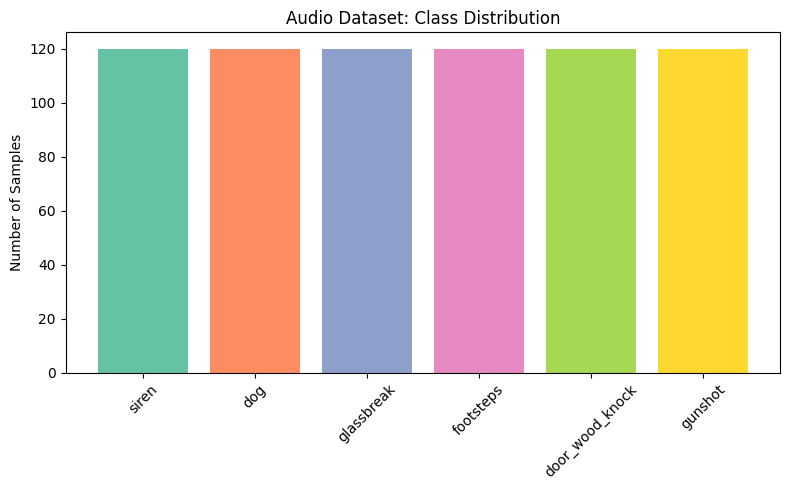

In [30]:
import matplotlib.pyplot as plt
from pathlib import Path

# Use the repo's outputs folder instead of hard-coding your Desktop
audio_dir = ROOT / "outputs" / "final_intruder_audio"

print("Audio dir:", audio_dir)
audio_class_counts = {}

# Count number of WAV files in each class folder
for cls in os.listdir(audio_dir):
    cls_path = os.path.join(audio_dir, cls)
    if os.path.isdir(cls_path):
        count = len([f for f in os.listdir(cls_path) if f.endswith(".wav")])
        audio_class_counts[cls] = count

# Get classes and values
classes = list(audio_class_counts.keys())
counts = list(audio_class_counts.values())

# Assign a unique color for each class using a colormap
colors = plt.cm.Set2(range(len(classes)))

# Plotting
plt.figure(figsize=(8, 5))
plt.bar(classes, counts, color=colors)
plt.title("Audio Dataset: Class Distribution")
plt.ylabel("Number of Samples")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [31]:
import os, shutil, glob, tempfile, tensorflow_hub as hub

# Option A: point TF-Hub to a fresh cache dir
fresh_cache = os.path.expanduser("~/tfhub_cache_clean")
os.makedirs(fresh_cache, exist_ok=True)
os.environ["TFHUB_CACHE_DIR"] = fresh_cache

# Option B: (optional) nuke any temp tfhub caches under /var/folders
for p in glob.glob(os.path.join(tempfile.gettempdir(), "tfhub_modules", "*")):
    try: shutil.rmtree(p, ignore_errors=True)
    except Exception as e: print("skip", p, e)

# Now try to load YAMNet again
import tensorflow_hub as hub
yamnet_model = hub.load('https://tfhub.dev/google/yamnet/1')
print("✅ YAMNet loaded")

✅ YAMNet loaded


In [43]:


# === CONFIG ===
# Final intruder audio dataset inside repo outputs
data_dir = ROOT / "outputs" / "final_intruder_audio"

# Pretrained YAMNet model (TensorFlow Hub link – no change needed)
yamnet_model_handle = 'https://tfhub.dev/google/yamnet/1'

print("Data dir:", data_dir)

# === Load YAMNet ===
yamnet_model = hub.load(yamnet_model_handle)

# === Audio to Feature Function ===
def extract_yamnet_features(file_path):
    waveform, sr = librosa.load(file_path, sr=16000)
    scores, embeddings, _ = yamnet_model(waveform)
    return tf.reduce_mean(embeddings, axis=0).numpy()

# === Load Data ===
features = []
labels = []

for label in sorted(os.listdir(data_dir)):
    class_dir = os.path.join(data_dir, label)
    if not os.path.isdir(class_dir):  
        continue
    for fname in os.listdir(class_dir):
        if not fname.endswith(".wav"):
            continue
        fpath = os.path.join(class_dir, fname)
        try:
            emb = extract_yamnet_features(fpath)
            features.append(emb)
            labels.append(label)
        except Exception as e:
            print(f"⚠️ Failed on {fname}: {e}")

print(f"✅ Loaded {len(features)} samples")

# === Encode Labels ===
le = LabelEncoder()
y = le.fit_transform(labels)
X = np.array(features)

# === Train/Test Split ===
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

#  MLP Classifier
model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(1024,)),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(len(le.classes_), activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

# === Train ===
history = model.fit(X_train, y_train, epochs=50, batch_size=16, validation_split=0.1)

# === Evaluate ===
y_pred = model.predict(X_test).argmax(axis=1)
print("\n🧪 Classification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))


test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
acc_original = test_accuracy * 100  # store for plotting later




Data dir: /Users/adarshthakur/Downloads/untitled folder/outputs/final_intruder_audio
✅ Loaded 720 samples
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 512)               524800    
                                                                 
 dropout_3 (Dropout)         (None, 512)               0         
                                                                 
 dense_10 (Dense)            (None, 128)               65664     
                                                                 
 dense_11 (Dense)            (None, 6)                 774       
                                                                 
Total params: 591238 (2.26 MB)
Trainable params: 591238 (2.26 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
33/33 [==========================

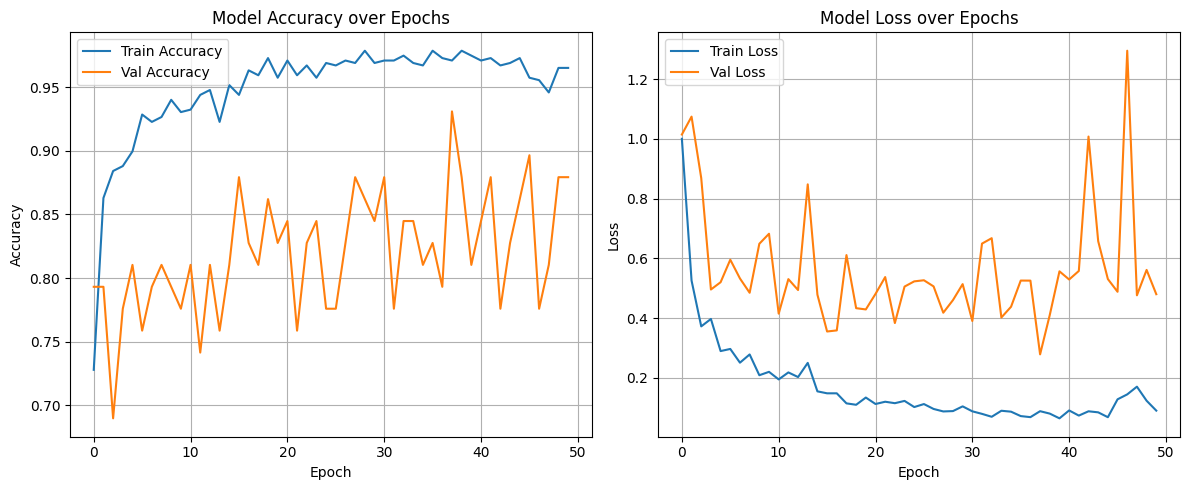

In [34]:
import matplotlib.pyplot as plt

# === Plot Training & Validation Accuracy and Loss ===
plt.figure(figsize=(12, 5))

# 📈 Accuracy Curve
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# 📉 Loss Curve
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [35]:
model.save("intruder_audio_model.keras")


In [36]:
import os
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import librosa
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score

# Load YAMNet Model 
yamnet_model = hub.load('https://tfhub.dev/google/yamnet/1')

# Path to original test audio (inside repo outputs)
test_audio_dir = ROOT / "outputs" / "final_intruder_audio"

print("Test audio dir:", test_audio_dir)

# Get class folders only (skip .DS_Store etc.)
classes = sorted([
    f for f in os.listdir(test_audio_dir)
    if os.path.isdir(os.path.join(test_audio_dir, f)) and not f.startswith('.')
])

# Label Encoder 
le = LabelEncoder()
le.fit(classes)

# Light Augmentation Function (pitch shift + time stretch)
def light_augment(file_path):
    y, sr = librosa.load(file_path, sr=16000)
    y = librosa.effects.pitch_shift(y=y, sr=sr, n_steps=np.random.choice([-1, 1]))
    y = librosa.effects.time_stretch(y, rate=np.random.uniform(0.9, 1.1))
    scores, embeddings, _ = yamnet_model(y)
    return tf.reduce_mean(embeddings, axis=0).numpy()

# Heavy Augmentation Function (add Gaussian noise)
def heavy_augment(file_path):
    y, sr = librosa.load(file_path, sr=16000)
    noise = np.random.normal(0, 0.04, len(y))
    y = np.clip(y + noise, -1.0, 1.0)
    scores, embeddings, _ = yamnet_model(y)
    return tf.reduce_mean(embeddings, axis=0).numpy()

# Build Augmented Test Set
def build_augmented_set(mode="light"):
    X_aug, y_aug = [], []

    for label in classes:
        folder = os.path.join(test_audio_dir, label)
        for fname in os.listdir(folder):
            if not fname.endswith(".wav"):
                continue
            path = os.path.join(folder, fname)
            try:
                if mode == "light":
                    emb = light_augment(path)
                elif mode == "heavy":
                    emb = heavy_augment(path)
                else:
                    continue
                X_aug.append(emb)
                y_aug.append(label)
            except Exception as e:
                print(f" Error on {fname}: {e}")
    
    return np.array(X_aug), le.transform(np.array(y_aug))

# === Evaluate on Light Augmented Test Set
print("Evaluating on LIGHT augmented test set...")
X_light, y_light = build_augmented_set("light")
y_pred_light = model.predict(X_light).argmax(axis=1)
acc_light = accuracy_score(y_light, y_pred_light)
print(f"Accuracy on Light Augmented Data: {acc_light * 100:.2f}%")

acc_light = accuracy_score(y_light, y_pred_light) * 100

# === Evaluate on Heavy Augmented Test Set
print("Evaluating on HEAVY augmented test set...")
X_heavy, y_heavy = build_augmented_set("heavy")
y_pred_heavy = model.predict(X_heavy).argmax(axis=1)
acc_heavy = accuracy_score(y_heavy, y_pred_heavy)
print(f"Accuracy on Heavy Augmented Data: {acc_heavy * 100:.2f}%")
acc_heavy = accuracy_score(y_heavy, y_pred_heavy) * 100

Test audio dir: /Users/adarshthakur/Downloads/untitled folder/outputs/final_intruder_audio
Evaluating on LIGHT augmented test set...
23/23 [==============================] - 0s 555us/step
Accuracy on Light Augmented Data: 82.36%
Evaluating on HEAVY augmented test set...
23/23 [==============================] - 0s 503us/step
Accuracy on Heavy Augmented Data: 53.19%


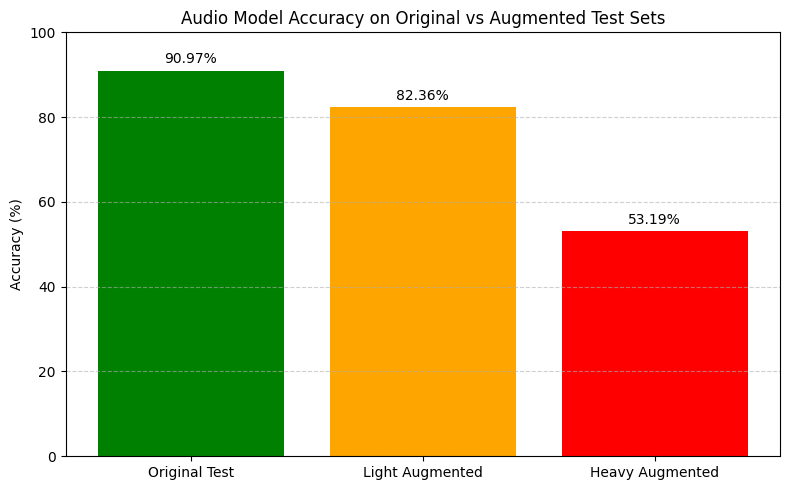

In [37]:
import matplotlib.pyplot as plt


# acc_original, acc_light, acc_heavy

labels = ['Original Test', 'Light Augmented', 'Heavy Augmented']
accuracies = [acc_original, acc_light, acc_heavy]
colors = ['green', 'orange', 'red']

plt.figure(figsize=(8, 5))
bars = plt.bar(labels, accuracies, color=colors)

# Add labels
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2.0, height + 1, f'{height:.2f}%', ha='center', va='bottom')

# Style
plt.ylim(0, 100)
plt.ylabel('Accuracy (%)')
plt.title('Audio Model Accuracy on Original vs Augmented Test Sets')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [38]:
print(f"Shape: {y_pred.shape}")
print(f"Type: {type(y_pred)}")


Shape: (144,)
Type: <class 'numpy.ndarray'>


In [39]:
y_test_probs = model.predict(X_test)  # Shape: (num_samples, num_classes)
print(f"Shape: {y_test_probs.shape}")
print(f"Row sums (should be ~1): {np.round(np.sum(y_test_probs, axis=1)[:5], 4)}")


5/5 [==============================] - 0s 948us/step
Shape: (144, 6)
Row sums (should be ~1): [1. 1. 1. 1. 1.]


In [40]:
# from  YAMNet+MLP pipeline
# y_test_probs: shape (M, 6)   — softmax outputs
# y_test:       shape (M,)     — encoded labels 0..5
AUDIO_CLASSES = ["dog","door_wood_knock","footsteps","glassbreak","gunshot","siren"]

audio_df = pd.DataFrame(y_test_probs, columns=[f"audio_{c}" for c in AUDIO_CLASSES])
audio_df["audio_pred"] = np.argmax(y_test_probs, axis=1)
audio_df["audio_true"] = y_test
audio_df["row_id"] = np.arange(len(audio_df))     # simple identifier; add filenames if you have them

audio_csv = "audio_probs.csv"
audio_df.to_csv(audio_csv, index=False)
print(f" Saved audio probabilities → {audio_csv} ({len(audio_df)} rows)")
print(audio_df.head())


 Saved audio probabilities → audio_probs.csv (144 rows)
      audio_dog  audio_door_wood_knock  audio_footsteps  audio_glassbreak  \
0  5.797798e-01           3.512296e-01     6.869167e-02      2.780458e-07   
1  8.605683e-17           4.564650e-21     9.922802e-20      8.574910e-14   
2  9.997792e-01           8.287889e-09     1.727541e-07      3.195621e-08   
3  1.604895e-20           2.574433e-22     1.327756e-20      7.093906e-15   
4  2.297025e-09           1.471252e-07     2.587048e-06      9.894502e-07   

   audio_gunshot   audio_siren  audio_pred  audio_true  row_id  
0   5.760746e-06  2.928624e-04           0           0       0  
1   2.793131e-14  1.000000e+00           5           5       1  
2   2.194708e-04  1.170791e-06           0           0       2  
3   4.226677e-18  1.000000e+00           5           5       3  
4   9.999963e-01  7.534185e-09           4           4       4  
